In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Read data and processing

In [520]:
data = pd.read_csv('Stars_original.csv')
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [521]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [522]:
a = data.to_numpy()
a

array([[3068, 0.0024, 0.17, ..., 'Red', 'M', 'Red Dwarf'],
       [3042, 0.0005, 0.1542, ..., 'Red', 'M', 'Red Dwarf'],
       [2600, 0.0003, 0.102, ..., 'Red', 'M', 'Red Dwarf'],
       ...,
       [8829, 537493.0, 1423.0, ..., 'White', 'A', 'Hypergiant'],
       [9235, 404940.0, 1112.0, ..., 'White', 'A', 'Hypergiant'],
       [37882, 294903.0, 1783.0, ..., 'Blue', 'O', 'Hypergiant']],
      dtype=object)

In [523]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [524]:
# Label encoding
def label_encoding(data,column):
    dict_label = {infor : label for label,infor in enumerate(data[column].unique())}
    # map key
    return data[column].map(dict_label)
    

In [525]:
# label encoding
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = label_encoding(data,i)

In [526]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0


In [527]:
data['Type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

## Training

### Extract feature

In [528]:
X,y = data.drop('Type',axis=1),data['Type']

In [529]:
class LDA:
        '''
        Inverse transform

        Atributes:
        X_transformed: numpy array, shape = [n_samples,n_components]
        Returns:
        X_projected: numpy array, shape = [n_samples,n_features]
    
        '''
        def __init__(self,n_components):
            '''
            Parameters:
            n_components: int, default = 2

            '''
            self.n_components = n_components
            self.linear_discriminants = None
        def fit(self,X,y):

            '''
            Parameters:
            X: numpy array, shape = [n_samples,n_features]
            y: numpy array, shape = [n_samples,]
            '''
            n_features = X.shape[1]
            class_lables = np.unique(y)

            # S_W , S_B
            mean_overall = np.mean(X,axis = 0)
            S_W = np.zeros((n_features,n_features))
            S_B = np.zeros((n_features,n_features))

            for c in class_lables:
                X_c = X[y == c]
                mean_c = np.mean(X_c,axis = 0)
                # 4,4
                S_W += (X_c - mean_c).T.dot(X_c - mean_c)
                n_c = X_c.shape[0]
                mean_diff = (mean_c - mean_overall).reshape(n_features,1)
                S_B += n_c * (mean_diff).dot(mean_diff.T)
            A = np.linalg.inv(S_W).dot(S_B)
            # Same PCA
            eigenvalues,eigenveactors = np.linalg.eig(A)
            eigenveactors = eigenveactors.T
            indexs = np.argsort(abs(eigenvalues))[::-1]
            eigenvalues = eigenvalues[indexs]
            eigenvectors = eigenveactors[indexs]
            self.linear_discriminants = eigenvectors[0:self.n_components]

        def transform(self,X):

            '''
            Parameters:
            X: numpy array, shape = [n_samples,n_features]
            '''
            return np.dot(X,self.linear_discriminants.T)

In [530]:
lda = LDA(n_components=4)
lda.fit(X.to_numpy(),y)
X = lda.transform(X.to_numpy())
y = y.to_numpy()

In [531]:
# Get test and train data from X using sample in numpy
def train_test_split(X,y,test_size):
    # Get index
    index = np.arange(X.shape[0])
    # Shuffle index
    np.random.shuffle(index)
    # Get test size
    test_size = int(X.shape[0] * test_size)
    # Get test and train index
    test_index = index[:test_size]
    train_index = index[test_size:]
    # Get test and train data
    X_train,y_train = X[train_index],y[train_index]
    X_test,y_test = X[test_index],y[test_index]
    return X_train,y_train,X_test,y_test

In [532]:
X_train,y_train,X_test,y_test = train_test_split(X,y,test_size=0.2)

### Softmax Regression

In [533]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:
    '''
        Me
    '''
    def __init__(self, n_iter = 10000, thres=1e-3):
        self.n_iter = n_iter
        self.thres = thres
    
    def fit(self, X, y, batch_size=64, lr=0.01, rand_seed=4, verbose=False): 
        np.random.seed(rand_seed) 
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.acc = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose)
        return self
 
    def fit_data(self, X, y, batch_size, lr, verbose):
        i = 0
        while (not self.n_iter or i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            error = y_batch - self.predict_(X_batch)
            update = (lr * np.dot(error.T, X_batch))
            self.weights += update
            if np.abs(update).max() < self.thres: break
            self.acc.append(self.evaluate_(X, y))
            if i % 100 == 0 and verbose: 
                print('Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1
                
    
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))
  
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
  
    def get_randon_weights(self, row, col):
        return np.zeros(shape=(row,col))

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
    
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))
    
    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

In [549]:
idx = np.random.choice(X_train.shape[0], 1000)
idx

array([180, 162,  43, 118,  80, 178, 164,  68, 146, 172,  18, 128, 180,
        34,  26, 152, 164, 111,  58, 117, 158, 159,  47,  53, 189,  80,
        48, 170, 124, 181,  40, 152,  38,  11,  42,  99, 184,  51,   1,
        12, 183, 132, 183, 191, 132, 154,  89,   1,  22,  74, 155, 173,
       182, 161, 108,  70,  56,  60,  89, 152,  72, 156, 161, 109, 132,
       168, 178,  31, 183,  40, 185,  30, 100,  32, 173, 123,  29,   8,
       134,  30,  53, 102, 130, 119,  66, 128,  24,  84, 146,  43,  30,
        75,  92,  15,  54, 117,  72, 102,  17, 158,  65,  78,  14, 107,
       132,  26,  76,  24,  20, 112, 164,  70,  64, 171, 154, 185,  50,
        54,  39, 181, 176, 138,  38,  13,  29,  33,  89,  16, 191,  71,
       128,  89, 136,  27, 154, 141,  90,  28,  48,  85, 173,  12, 108,
        25,  21,  85, 153, 119, 164,  89, 102,  66,  53, 184,  57, 133,
       171, 102, 107,  27, 116,   3,  52,  66, 149,  47,  48, 179,  27,
       131, 169,  38,  68,  53, 191,  19, 178, 130,  40, 153,  6

In [541]:
multi = MultiClassLogisticRegression(n_iter= 2500)
multi.fit(X_train,y_train,lr=0.001,verbose=False)
print('Score: ',multi.score(X_test,y_test))

Score:  1.0


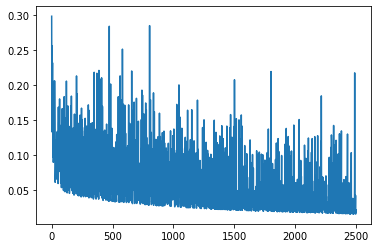

In [542]:
plt.plot(multi.loss)

In [543]:
multi.class_labels

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [544]:
np.vectorize(lambda c: multi.class_labels[c])(y_train).reshape(-1)

array([1, 2, 0, 2, 3, 4, 1, 2, 3, 5, 5, 1, 5, 4, 5, 3, 5, 3, 5, 1, 1, 4,
       1, 2, 3, 1, 5, 2, 5, 0, 3, 5, 5, 3, 3, 2, 0, 4, 4, 2, 0, 1, 3, 2,
       2, 5, 2, 4, 5, 4, 2, 5, 5, 4, 4, 3, 1, 2, 4, 1, 2, 1, 4, 1, 3, 2,
       1, 3, 0, 3, 0, 1, 0, 0, 2, 0, 5, 0, 3, 5, 1, 4, 0, 2, 4, 3, 4, 0,
       1, 5, 4, 2, 3, 3, 0, 5, 2, 5, 4, 3, 3, 3, 3, 4, 2, 1, 5, 4, 1, 5,
       3, 3, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 3, 0, 3, 4, 0, 4, 0, 2,
       2, 0, 3, 4, 0, 4, 3, 1, 2, 3, 1, 1, 4, 1, 2, 0, 5, 0, 1, 4, 1, 3,
       1, 5, 4, 5, 5, 5, 2, 4, 2, 1, 3, 4, 3, 0, 4, 2, 2, 1, 4, 3, 2, 4,
       5, 1, 0, 0, 3, 0, 5, 3, 2, 5, 2, 2, 4, 2, 1, 5])

In [547]:
np.eye(6)[np.vectorize(lambda c: multi.class_labels[c])(y_train).reshape(-1)],np.eye(6)[(y_train).reshape(-1)]


(array([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]]),
 array([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]]))

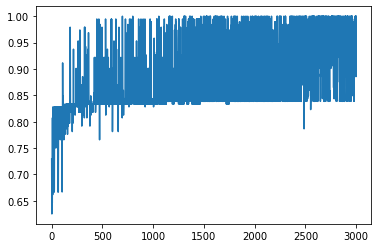

In [539]:
plt.plot(multi.acc)

In [540]:
z = np.array([1,2,3,4,5])
z = np.exp(z) / np.sum(np.exp(z), axis=0).reshape(-1,1)
print(z)

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]


https://phamdinhkhanh.github.io/2020/07/25/GAN_Wasserstein.html